# Laboratorio No. 4
- Ricardo Méndez 21289
- Sara Echeverría 21371
- Francisco Castillo 21562
- Melissa Pérez 21385

Enlace al repositorio: [https://github.com/bl33h/bankCustomerSegmentation]

# Task 1

### ¿Qué son los grafos computacionales? y ¿cuál es su importancia para el cálculo de gradientes en aplicaciones como backpropagation?
Los grafos computacionales son una representación visual y matemática donde sus nodos corresponden a una operación y los arcos los valores de entrada/salida. Se usan comúnmente para descibir algoritmos y modelos de aprendizaje automático. En el cálculo de gradientes toman un papel importante porque proporcionan una representación clara y estructurada de las operaciones. Lo cual ayuda a que las conexiones entre nodos representen el flujo de datos entre las operaciones. Además, los grafos computacionales permiten realizar el cálculo de los gradientes de forma óptima, lo que ayuda a entrenar modelos por medio de algoritmos.

[Understanding Gradient Descent and Backpropagation](https://www.shramos.com/2019/02/understanding-gradient-descent-and_3.html)

### Detalle cuales son los componentes y pasos que conforman una red neuronal. Con esto en mente, ¿cómo mejoraría el perceptrón que hizo en el laboratorio pasado?

### ¿Cómo se selecciona el valor K usando el método de la silueta para el algoritmo de K-Means. Explique las fórmulas (ecuaciones) que lo componen así como las asumpciones, si hay.

### Investigue sobre Principal Component Analysis (PCA) y responda respecto a algoritmos como K-Means ¿Cómo podría ayudarle a mejorar la calidad de sus clusters cuando se usa K-Means?

# Análisis exploratorio

In [222]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
plt.style.use('ggplot')

In [223]:
df = pd.read_csv('data/bank_transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [224]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB
None


In [225]:
print(df.describe())

       CustAccountBalance  TransactionTime  TransactionAmount (INR)
count        1.046198e+06     1.048567e+06             1.048567e+06
mean         1.154035e+05     1.570875e+05             1.574335e+03
std          8.464854e+05     5.126185e+04             6.574743e+03
min          0.000000e+00     0.000000e+00             0.000000e+00
25%          4.721760e+03     1.240300e+05             1.610000e+02
50%          1.679218e+04     1.642260e+05             4.590300e+02
75%          5.765736e+04     2.000100e+05             1.200000e+03
max          1.150355e+08     2.359590e+05             1.560035e+06


In [226]:
# relevant columns in the dataframe
selected_features = [
    'CustGender',               # To get the gender
    'CustAccountBalance',       # To get the account balance
    'TransactionTime',          # To get the time of the transaction (It's a timestamp of the transaction HHMMSS, needs to be transformed)
    'TransactionAmount (INR)',  # To get the amount of the transaction in rupees
]

features = df[selected_features]

In [227]:
# check for missing values
features.isnull().sum()

CustGender                 1100
CustAccountBalance         2369
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [228]:
# check for duplicates
features.duplicated().sum()

68

In [229]:
# Remove duplicates and missing values
features = features.dropna()
features = features.drop_duplicates()

In [230]:
features.count()

CustGender                 1045031
CustAccountBalance         1045031
TransactionTime            1045031
TransactionAmount (INR)    1045031
dtype: int64

### Encoding y transformación de valores

In [231]:
# categorical features and change other values to its numerical representation
features['CustGender'] = features['CustGender'].map({'F': 1, 'M': 0}) # 1 for female and 0 for male

# rename column
features.rename(
    columns={
        'CustGender': 'Female?',
        'CustAccountBalance': 'Balance',
        'TransactionAmount (INR)': 'Amount',
    }, 
    inplace=True)

In [232]:
features.count()

Female?            1045030
Balance            1045031
TransactionTime    1045031
Amount             1045031
dtype: int64

In [233]:
# To get the hour of the transaction. Since it's timestamp HHMMSS, needs to be transformed

# Get the first 2 characters of the string
features['TransactionTime'] = features['TransactionTime'].astype(str).str[:2]

# Change the type of the column to int
features['TransactionTime'] = features['TransactionTime'].astype(int)

# Rename the column
features.rename(columns={'TransactionTime': 'Hour'}, inplace=True)

In [234]:
features.head()

,Female?,Balance,Hour,Amount
0,1.0,17819.05,14,25.0
1,0.0,2270.69,14,27999.0
2,1.0,17874.44,14,459.0
3,1.0,866503.21,14,2060.0
4,1.0,6714.43,18,1762.5


### Balanceo de clases

En este caso la variable de interés 'CustGender' sí está desbalanceada, por lo que es pertinente aplicar una técnica para corregirlo.

In [235]:
features['Female?'].value_counts()

Female?
0.0    763769
1.0    281261
Name: count, dtype: int64

In [236]:
male = features[features['Female?'] == 0]
female = features[features['Female?'] == 1]
male = male.sample(n=len(female), random_state=7)
features = pd.concat([male, female])

In [237]:
features['Female?'].value_counts()

Female?
0.0    281261
1.0    281261
Name: count, dtype: int64

### Scaling
Las magnitudes de los datos varían significativamente, por lo que es necesario escalar los valores de 'TransactionTimeSeconds' y 'TransactionAmount (INR)'.

In [238]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [239]:
# Create a copy of the dataframe with scaled features (for it to be used for clustering, classify, then analyze the data with the original features)
scaled_features = features.copy()

# Scale the features
to_scale = ['Amount', 'Hour', 'Balance']

# Scale the features
scaled_features[to_scale] = scaler.fit_transform(scaled_features[to_scale])

# Show the scaled features
scaled_features.head()

,Female?,Balance,Hour,Amount
438920,0.0,-0.121836,-0.062229,-0.235851
165307,0.0,-0.108922,-0.117575,-0.061158
428353,0.0,-0.068824,-0.228267,-0.122073
715304,0.0,-0.133332,-0.172921,-0.179645
170370,0.0,-0.049026,-0.283612,-0.198185


### Feature selection
Debido a la naturaleza del objetivo para este dataframe, el cual es segmentar a clientes de una entidad bancaria para poder así tomar decisiones a nivel comercial y
potenciar las operaciones de la empresa. Los features considerados de utilidad son:
- 'Female?': para identificar el género del cliente (1 para mujer, 0 para hombre)
- 'Amount': para identificar el monto de la transacción realizada por el cliente
- 'Hour': para identificar la hora en la que se realizó la transacción
- 'Balance': para identificar el valor de la cuenta del cliente

En términos generales, las variables del dataframe no se encontraban en óptimas condiciones para la implementación del modelo no supervisado, por lo que se realizaron acciones como encoding, scaling y balanceo de clases. Los features expuestos anteriormente representan temas de interés para una entidad bancaria, ya que con estos es posible la identificación de fenómenos como las transacciones fraudulentas, permitiendo la visualización de alguna correlación entre el género, el monto de las transacciones realizadas por el cliente, el valor de la cuenta, entre otros. Por dicha razón, se seleccionaron los features: 'CustGender', 'TransactionAmount (INR)', 'TransactionTimeSeconds' y 'CustAccountBalance'.

# Task 2.1 K-Means

## ¿Es necesario hacer un split del dataset? ¿Por qué?
No, el objetivo de hacer un split de los datos es el poder evaluar el desempeño del modelo. Al ser no supervisado, el hacer esto puede ser contraproducente, ya que no se cuenta con un target para evaluar el desempeño del modelo. Por lo que se puede utilizar el dataset completo para el entrenamiento del modelo.

## Selección del número de clusters

In [ ]:
from sklearn.cluster import KMeans

In [241]:
# List to save the inertia for each number of clusters
inertia_values = []

# Range of cluster numbers to check
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=7)
    kmeans.fit(scaled_features)
    inertia_values.append(kmeans.inertia_)

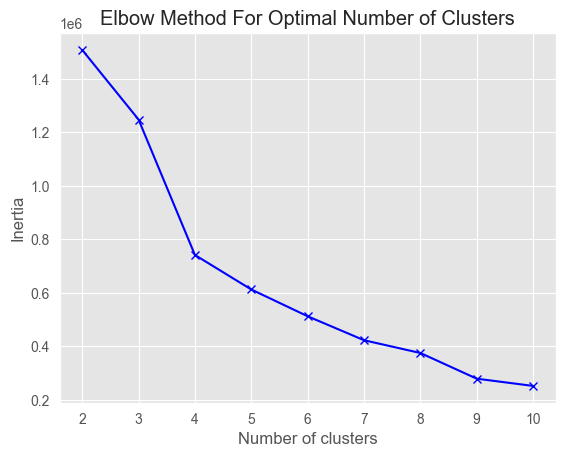

In [242]:
# Plotting the inertia values
plt.plot(cluster_range, inertia_values, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()

# Task 2.2 Mixture Models